## Burgers: One-pfive step Method

In [29]:
# Import packages
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics.pairwise import polynomial_kernel
from tqdm import tqdm
import jax.numpy as jnp
from jax import grad, jit
from jaxopt import LBFGS
from jaxopt import GradientDescent
from functools import partial
from jax.config import config;
sys.path.append('/home/juanfelipe/Desktop/research/keql/source')
from parameter_learning import *
from plotlib import *
from models import * 
from kernels import *
from data_loader_Burgers import *
from loss import *
from utils import *


os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
config.update("jax_enable_x64", True)

In [30]:
# Import values from 2-step
two_step_dict = np.load('data/two_step_dict.npy', allow_pickle=True)
two_step_dict = two_step_dict.item()
two_step_dict

{'optim_sgm_u': array([5.32195986, 7.09163991]),
 'optim_nugget_u': array([1.e-08, 1.e-08]),
 'rkhs_u': [165490.2641061442],
 'optim_sgm_P': 2,
 'optim_nugget_P': 1e-16,
 'nugget_P': 1e-07,
 'rkhs_P_train': 0.1501236544589095,
 'f_gh_tr_pred': array([-2.72635069e-03, -2.23100556e-03, -1.98253874e-03, -1.95400205e-03,
        -2.10065485e-03, -2.37383809e-03, -2.74580094e-03, -3.15623388e-03,
        -3.59632309e-03, -4.02639878e-03, -1.73936469e-02, -1.62613705e-02,
        -1.46239175e-02, -1.26397201e-02, -1.03656574e-02, -8.11364495e-03,
        -5.91915675e-03, -4.00737060e-03, -2.31904619e-03, -9.66944041e-04,
        -6.90604970e-03, -4.72911969e-03, -2.20312823e-03,  3.84093219e-04,
         2.92553081e-03,  5.07762205e-03,  6.82230811e-03,  7.98780427e-03,
         8.61393354e-03,  8.67376135e-03,  5.05419588e-03,  5.73112861e-03,
         6.34395807e-03,  6.82385873e-03,  7.12482722e-03,  7.13490579e-03,
         6.76321090e-03,  5.96897848e-03,  4.68444031e-03,  3.00839737e-0

### Cost function

Create objective function `L`

$$
L(Z_0) = f(X_N)^T \Gamma(S_N,S_N)^{-1} f(X_N) + \lambda \sum_{i=1}^m (Z_{0,i*N:(i+1)*N})^T K(X_N,X_N)^{-1}(Z_{0,i*N:(i+1)*N})
$$
where
$$
Z_0[M] = U[M].
$$

In [31]:
# First column in Gamma(S_N_gh_tr,S_N_gh_tr)
X = X_gh_tr # (N_gh_tr*m, 2)

# Second column in Gamma(S_N_gh_tr,S_N_gh_tr)
U = U_gh_tr.reshape(N_gh_tr*m,) # (N_gh_tr*m, )

# f(X_N)
f = two_step_dict['f_gh_tr_pred']

In [32]:
# Load values of U predicted from 2-step at gh_tr points
U_gh_tr_pred = np.load('data/U_gh_tr_pred.npy')
U_x_gh_tr_pred = np.load('data/U_x_gh_tr_pred.npy')
U_xx_gh_tr_pred = np.load('data/U_xx_gh_tr_pred.npy')
# Build Z_warm
Z_warm = jnp.array(U_gh_tr_pred.T.reshape(N_gh_tr*m,)) 

First iteration RKHS norm of P 

Gaussian

In [33]:
# S = jnp.zeros((N_gh_tr*m, 5))

# # Split Z
# for i in range(m):
#     Zi = Z_warm[i*N_gh_tr:(i+1)*N_gh_tr]
#     optim_sgm = two_step_dict.get('optim_sgm_u')[i]
#     optim_nugget = two_step_dict.get('optim_nugget_u')[i]
#     G = K_2D(Gaussian2D, X[:N_gh_tr], X[:N_gh_tr], optim_sgm) 
#     alphas = jnp.linalg.solve(G + optim_nugget*jnp.eye(N_gh_tr),Zi)

#     Zi_x = jnp.dot(K_dot2D(Gaussian2D, X[:N_gh_tr], X[:N_gh_tr], optim_sgm, 1), alphas)
#     Zi_xx = jnp.dot(K_2dot2D(Gaussian2D, X[:N_gh_tr], X[:N_gh_tr], optim_sgm, 1,1), alphas)

#     Si = jnp.vstack((X[:N_gh_tr].T, Zi, Zi_x,Zi_xx)).T
#     # print shapes and values here
#     S = S.at[i*N_gh_tr:(i+1)*N_gh_tr,:].set(Si)
# # Scaling S_N
# scaler_S_gh_tr = MinMaxScaler()
# S = scaler_S_gh_tr.fit_transform(S)
# S = jnp.array(S)
# # Gamma(S_N,S_N)
# optim_sgm_P = two_step_dict.get('optim_sgm_P')
# Gamma = K(Gaussian, S, S, optim_sgm_P)
# nugget_P = two_step_dict.get('optim_nugget_P') 
# Gamma = Gamma + nugget_P*jnp.eye(jnp.size(Gamma,0))
# #print("cond(Gamma) = ", jnp.linalg.cond(Gamma))

# # (Gamma(S_N,S_N) + alpha_Gamma*I)^-1 * f
# b = jnp.linalg.solve(Gamma,f)

# rkhs_P_first_iter = jnp.dot(f.T , b)

Poly2

In [34]:
S = jnp.zeros((N_gh_tr*m, 5))

# Split Z
for i in range(m):
    Zi = Z_warm[i*N_gh_tr:(i+1)*N_gh_tr]
    optim_sgm = two_step_dict.get('optim_sgm_u')[i]
    optim_nugget = two_step_dict.get('optim_nugget_u')[i]
    G = K_2D(Gaussian2D, X[:N_gh_tr], X[:N_gh_tr], optim_sgm) 
    alphas = jnp.linalg.solve(G + optim_nugget*jnp.eye(N_gh_tr),Zi)

    Zi_x = jnp.dot(K_dot2D(Gaussian2D, X[:N_gh_tr], X[:N_gh_tr], optim_sgm, 1), alphas)
    Zi_xx = jnp.dot(K_2dot2D(Gaussian2D, X[:N_gh_tr], X[:N_gh_tr], optim_sgm, 1,1), alphas)

    Si = jnp.vstack((X[:N_gh_tr].T,Zi, Zi_x,Zi_xx)).T
    # print shapes and values here
    S = S.at[i*N_gh_tr:(i+1)*N_gh_tr,:].set(Si)
# Scaling S_N
scaler_S_gh_tr = MinMaxScaler()
S = scaler_S_gh_tr.fit_transform(S)
S = jnp.array(S)
# Gamma(S_N,S_N)
optim_sgm_P = two_step_dict.get('optim_sgm_P')
Gamma = K(Polynomial,S, S, jnp.array([1,2]))
nugget_P = two_step_dict.get('nugget_P') 
Gamma = Gamma + nugget_P*jnp.eye(jnp.size(Gamma,0))
#print("cond(Gamma) = ", jnp.linalg.cond(Gamma))

# (Gamma(S_N,S_N) + alpha_Gamma*I)^-1 * f
b = jnp.linalg.solve(Gamma,f)

# First term
#L1 = jnp.dot(f.T , b) / two_step_dict.get('rkhs_P_train')
rkhs_P_first_iter = jnp.dot(f.T , b) 
print(rkhs_P_first_iter)

563.4962974442866


First iteration RKHS norm of u

In [36]:
# Second term
sigma_K = jnp.array(two_step_dict.get('optim_sgm_u'))
nugget_K = two_step_dict.get('optim_nugget_u')
K_XNs = []
for i in range(m):
    K_XN = K(Gaussian,X_gh_tr[:N_gh_tr],X_gh_tr[:N_gh_tr],sigma_K[i]) 
    K_XNs.append(K_XN + nugget_K[i]*jnp.eye(N_gh_tr))

rkhs_u_first_iter = []
for i in range(m):
    Zi = Z_warm[i*N_gh_tr:(i+1)*N_gh_tr]
    c = jnp.linalg.solve(K_XNs[i],Zi)
    rkhs_u_first_iter.append(jnp.reshape(jnp.dot(Zi.T , c),()))

print(rkhs_u_first_iter)

[Array(73299.14705087, dtype=float64), Array(11667.02529281, dtype=float64)]


In [37]:
def L(Z, X, U, M, f, two_step_dict, lmbd):
    """Cost function for 1.5-step method.
    
    Args:
        Z: Vector [Z^1 Z^2 Z^3]^T. m*N
        X: List of mN points of dimension d.
        U: List of N1+N2+N3 values of functions u^(1),...u^(N).
        M: Bolean array which contains where true values reside.
        f: List of mN values of functions u^(1),...u^(N).
        two_step_dict: Dictionary with values from 2-step.
        lmbd: Lagrange multiplier in the loss function.
    Returns:
        scalar: a cost of this solution.    
    """ 

    ### Set up
    N = 10*10
    m = 2
    #print('Z:', Z)
    # Constrain the value of Z with known info
    Z = jnp.where(M, U, Z)
    # Just use Z_warm instead of using line 21.
    # Cd + 1 = 4
    S = jnp.zeros((N_gh_tr*m, 5))
    
    # Split Z
    for i in range(m):
        Zi = Z[i*N_gh_tr:(i+1)*N_gh_tr]
        optim_sgm = two_step_dict.get('optim_sgm_u')[i]
        optim_nugget = two_step_dict.get('optim_nugget_u')[i]
        G = K_2D(Gaussian2D, X[:N_gh_tr], X[:N_gh_tr], optim_sgm) 
        alphas = jnp.linalg.solve(G + optim_nugget*jnp.eye(N),Zi)

        Zi_x = jnp.dot(K_dot2D(Gaussian2D, X[:N_gh_tr], X[:N_gh_tr], optim_sgm, 1), alphas)
        Zi_xx = jnp.dot(K_2dot2D(Gaussian2D, X[:N_gh_tr], X[:N_gh_tr], optim_sgm, 1,1), alphas)

        Si = jnp.vstack((X[:N].T,Zi, Zi_x,Zi_xx)).T
        # print shapes and values here
        S = S.at[i*N_gh_tr:(i+1)*N_gh_tr,:].set(Si)
    # Scaling S_N
    scaler_S_gh_tr = MinMaxScaler()
    S = scaler_S_gh_tr.fit_transform(S)
    S = jnp.array(S)
    # Gamma(S_N,S_N)
    optim_sgm_P = two_step_dict.get('optim_sgm_P')
    #Gamma = K(Gaussian, S, S, optim_sgm_P)
    Gamma = K(Polynomial,S, S, jnp.array([1,2]))
    nugget_P = two_step_dict.get('nugget_P') 
    Gamma = Gamma + nugget_P*jnp.eye(jnp.size(Gamma,0))
    #print("cond(Gamma) = ", jnp.linalg.cond(Gamma))

    # (Gamma(S_N,S_N) + alpha_Gamma*I)^-1 * f
    b = jnp.linalg.solve(Gamma,f)

    # First term
    #L1 = jnp.dot(f.T , b) / two_step_dict.get('rkhs_P_train')
    L1 = jnp.dot(f.T , b) / rkhs_P_first_iter
    print('L1: ', L1)

    # Second term
    sigma_K = jnp.array(two_step_dict.get('optim_sgm_u'))
    nugget_K = two_step_dict.get('optim_nugget_u')
    K_XNs = []
    for i in range(m):
        K_XN = K(Gaussian,X[:N_gh_tr],X[:N_gh_tr],sigma_K[i]) 
        K_XNs.append(K_XN + nugget_K[i]*jnp.eye(N_gh_tr))
    
    L2 = 0.
    
    for i in range(m):
        Zi = Z[i*N_gh_tr:(i+1)*N_gh_tr]
        c = jnp.linalg.solve(K_XNs[i],Zi)
        L2 += jnp.reshape(jnp.dot(Zi.T , c),()) / rkhs_u_first_iter[i]
        
        print('L2_',i+1,':',jnp.reshape(jnp.dot(Zi.T , c),()) / rkhs_u_first_iter[i])      
    return L1 + lmbd*L2
    

#### Gradient descent

Training data

In [38]:
# First column in Gamma(S_N,S_N)
X = X_gh_tr # (N_gh_tr*m, 2)

# Second column in Gamma(S_N,S_N)
U = U_gh_tr.reshape(N_gh_tr*m,) # N*m x 1

# f(X_N)
f = two_step_dict['f_gh_tr_pred']

Initial guess: `Z_warm`

In [39]:
# Load values of U predicted from 2-step at te points: originally wrong
U_gh_tr_pred = np.load('data/U_gh_tr_pred.npy')
U_x_gh_tr_pred = np.load('data/U_x_gh_tr_pred.npy')
U_xx_gh_tr_pred = np.load('data/U_xx_gh_tr_pred.npy')
# Build Z_warm
Z_warm = jnp.array(U_gh_tr_pred.T.reshape(N_gh_tr*m,)) 

In [40]:
lmbda = 1/m

In [41]:
L(Z_warm, X, U, M_gh_tr, f, two_step_dict, lmbd=lmbda)

L1:  51.82654247241623
L2_ 1 : 187.4026011047837
L2_ 2 : 249.11344744943412


Array(270.08456675, dtype=float64)

### Optimization of L

In [13]:
solver = LBFGS(fun=L, maxiter=1000, linesearch='backtracking', history_size = 20)
#solver = GradientDescent(fun=L, maxiter=50, stepsize=1e-7)
res = solver.run(Z_warm, X = X, U = U, M = M_gh_tr, f = f , two_step_dict=two_step_dict, lmbd=lmbda)

L1:  Traced<ConcreteArray(51.82654247241623, dtype=float64)>with<JVPTrace(level=2/1)> with
  primal = Array(51.82654247, dtype=float64)
  tangent = Traced<ShapedArray(float64[])>with<JaxprTrace(level=1/1)> with
    pval = (ShapedArray(float64[]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f8e887e36f0>, in_tracers=(Traced<ShapedArray(float64[]):JaxprTrace(level=1/1)>, Traced<ConcreteArray(563.4962974442866, dtype=float64):JaxprTrace(level=1/1)>), out_tracer_refs=[<weakref at 0x7f8e88311850; to 'JaxprTracer' at 0x7f8e883118f0>], out_avals=[ShapedArray(float64[])], primitive=pjit, params={'jaxpr': { lambda ; a:f64[] b:f64[]. let c:f64[] = div a b in (c,) }, 'in_shardings': (UnspecifiedValue, UnspecifiedValue), 'out_shardings': (UnspecifiedValue,), 'resource_env': None, 'donated_invars': (False, False), 'name': 'true_divide', 'keep_unused': False, 'inline': True}, effects=set(), source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x7f8e8848aab0>, n

In [14]:
Z = res.params

In [15]:
np.all(Z_warm==Z)

Array(False, dtype=bool)

Evaluate `Z`

In [16]:
S = jnp.zeros((N_gh_tr*m, 5))

# Split Z
for i in range(m):
    Zi = Z[i*N_gh_tr:(i+1)*N_gh_tr]
    optim_sgm = two_step_dict.get('optim_sgm_u')[i]
    optim_nugget = two_step_dict.get('optim_nugget_u')[i]
    G = K_2D(Gaussian2D, X[:N_gh_tr], X[:N_gh_tr], optim_sgm) 
    alphas = jnp.linalg.solve(G + optim_nugget*jnp.eye(N_gh_tr),Zi)
    Zi_x = jnp.dot(K_dot2D(Gaussian2D, X[:N_gh_tr], X[:N_gh_tr], optim_sgm, 1), alphas)
    Zi_xx = jnp.dot(K_2dot2D(Gaussian2D, X[:N_gh_tr], X[:N_gh_tr], optim_sgm, 1,1), alphas)
    Si = jnp.vstack((X[:N_gh_tr].T,Zi, Zi_x,Zi_xx)).T
    S = S.at[i*N_gh_tr:(i+1)*N_gh_tr,:].set(Si)



# Load gradients from 2-step
U_te_pred = np.load('data/U_te_pred.npy')
U_x_te_pred = np.load('data/U_x_te_pred.npy')
U_xx_te_pred = np.load('data/U_xx_te_pred.npy')
S_gh_tr = S
S_tr = S[M_gh_tr]
S_te = np.hstack((X_te, U_te.T.reshape(-1,1), U_x_te_pred.T.reshape(-1,1), U_xx_te_pred.T.reshape(-1,1))) # (N_te*m, 5)

f_gh_tr = two_step_dict['f_gh_tr_pred']
f_te = U_t_te.T.reshape(N_te*m,1).flatten()
f_gh_tr2 = -S_gh_tr[:,2]*S_gh_tr[:,3] + 0.01*S_gh_tr[:,4]
f_tr2 = -S_tr[:,2]*S_tr[:,3] + 0.01*S_tr[:,4]
f_te2 = -S_te[:,2]*S_te[:,3] + 0.01*S_te[:,4]

scaler_S_gh_tr = MinMaxScaler()
S_gh_tr_s = scaler_S_gh_tr.fit_transform(S_gh_tr)
S_tr_s = scaler_S_gh_tr.fit_transform(S_tr)
S_te_s = scaler_S_gh_tr.transform(S_te)

optim_sgm_P, optim_nugget_P = grid_search_RBF(S_gh_tr_s , f_gh_tr)

#krr_optimal_P = KernelRidge(kernel='rbf', alpha = two_step_dict.get('optim_nugget_P'), gamma=1/(2*(two_step_dict.get('optim_sgm_P')**2))) 
krr_optimal_P = KernelRidge(kernel='polynomial', degree = 2) 
krr_optimal_P.fit(S_gh_tr_s, f_gh_tr) 
f_gh_tr_pred = krr_optimal_P.predict(S_gh_tr_s)
f_tr_pred = krr_optimal_P.predict(S_tr_s) 
f_te_pred = krr_optimal_P.predict(S_te_s)

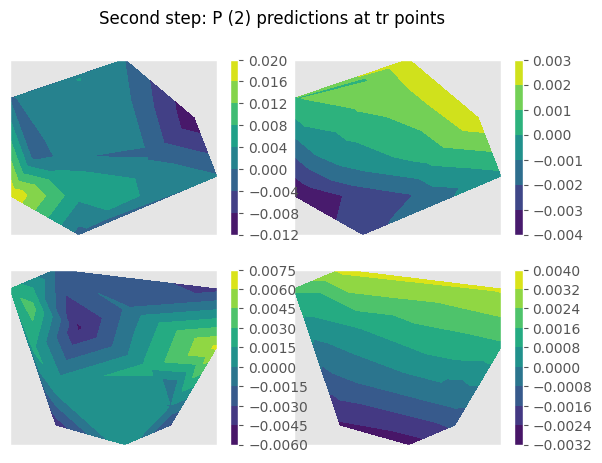

In [17]:
# Interpolant P^* at tr points : P^*(hat S_tr) vs. P(hat S_tr)
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 2, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('Second step: P ({}) predictions at tr points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(S_tr[i*N_tr:(i+1)*N_tr,0], S_tr[i*N_tr:(i+1)*N_tr,1], f_tr2[i*N_tr:(i+1)*N_tr])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(S_tr[i*N_tr:(i+1)*N_tr,0], S_tr[i*N_tr:(i+1)*N_tr,1], f_tr_pred[i*N_tr:(i+1)*N_tr])
        plt.colorbar(axsi1, ax = axs[i,1])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])

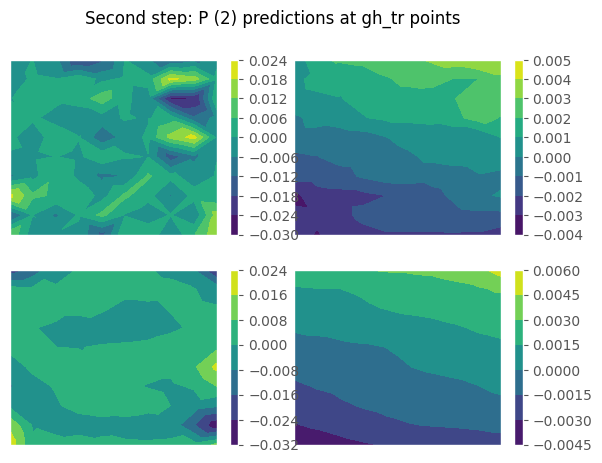

In [18]:
# Interpolant P^* at gh_tr points : P^*(hat S_gh_tr) vs. P(hat S_gh_tr)
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 2, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('Second step: P ({}) predictions at gh_tr points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(S[i*N_gh_tr:(i+1)*N_gh_tr,0], S[i*N_gh_tr:(i+1)*N_gh_tr,1], f_gh_tr2[i*N_gh_tr:(i+1)*N_gh_tr])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(S[i*N_gh_tr:(i+1)*N_gh_tr,0], S[i*N_gh_tr:(i+1)*N_gh_tr,1], f_gh_tr_pred[i*N_gh_tr:(i+1)*N_gh_tr])
        plt.colorbar(axsi1, ax = axs[i,1])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])

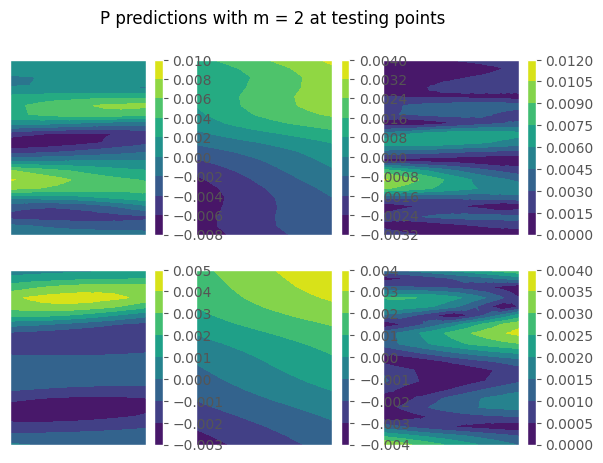

In [19]:
# Interpolant P^* at testing points : P^*(hat S) vs. P(hat S)
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 3, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('P predictions with m = {} at testing points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(X_te[i*N_te:(i+1)*N_te,0], X_te[i*N_te:(i+1)*N_te,1], f_te2[i*N_te:(i+1)*N_te])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(X_te[i*N_te:(i+1)*N_te,0], X_te[i*N_te:(i+1)*N_te,1], f_te_pred[i*N_te:(i+1)*N_te])
        plt.colorbar(axsi1, ax = axs[i,1])
        axsi2 = axs[i,2].tricontourf(X_te[i*N_te:(i+1)*N_te,0], X_te[i*N_te:(i+1)*N_te,1], np.abs(f_te2[i*N_te:(i+1)*N_te]-f_te_pred[i*N_te:(i+1)*N_te]))
        plt.colorbar(axsi2, ax = axs[i,2])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])
        axs[i,2].set_yticklabels([])
        axs[i,2].set_xticklabels([])
        axs[i,2].set_yticks([])
        axs[i,2].set_xticks([])

In [20]:
# NMSEs: P at training points and testing points
print('Normalized MSEs between P and P^ for {} functions'.format(m))
for i in range(m):
    n_mse_gh_train = rel_mse(f_gh_tr2[i*N_gh_tr:(i+1)*N_gh_tr],f_gh_tr_pred[i*N_gh_tr:(i+1)*N_gh_tr])
    n_mse_train = rel_mse(f_tr2[i*N_tr:(i+1)*N_tr], f_tr_pred[i*N_tr:(i+1)*N_tr])
    n_mse_test = rel_mse(f_te2[i*N_te:(i+1)*N_te], f_te_pred[i*N_te:(i+1)*N_te])
    print('m = {} nmse_ghost_train = {}'.format(i,n_mse_gh_train))
    print('m = {} nmse_train = {}'.format(i,n_mse_train))
    print('m = {} nmse_test = {}'.format(i,n_mse_test))

Normalized MSEs between P and P^ for 2 functions
m = 0 nmse_ghost_train = 1.0779201571826444
m = 0 nmse_train = 1.2290573076987379
m = 0 nmse_test = 1.0204997468946368
m = 1 nmse_ghost_train = 1.0999103311432532
m = 1 nmse_train = 1.142175602375557
m = 1 nmse_test = 0.8092294693253279
